In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import regex
from sklearn.neighbors import KDTree
from scipy.spatial import cKDTree
from scipy.integrate import simpson, trapezoid
import warnings

In [150]:
class Trajectory:
    '''
    Class to parse, manipulate and plot the lammps-trajectory objects.
    Takes one input argument 'file' which is the filepath of the .lammpstrj file to initialize
    - added functionality to also parse gromac trajectory .gro files.
    - TODO:: parse atom count from file instead of hardcode dummy -> only for gromac 
    '''

    def __init__(self, file, format='lammpstrj', scaled=1):
        '''
        init of trajectory class
        :param file: file path to get the trajectory from
        :param format: default "lammpstrj", optional "gromac" or "XDATCAR"
                NOTE: if you want to add more formats make sure to include the apropriate format_to_np() parsers 
                with the same output format as the included ones.
        '''
        self.file = file
        if format == 'lammpstrj':
            self.trajectory, self.box_dim, self.n_atoms = self.lammpstrj_to_np(scaled)
        if format == 'gromac':
               self.trajectory, self.box_dim = self.gromac_to_np()
        if format == 'XDATCAR':
            self.trajectory, self.box_dim = self.xdatcar_to_np()
        self.n_snapshots = len(self.box_dim)
        self.s1 = 0
        self.s2 = 0
        self.box_size = 0
        self.get_box_size()
        
        if scaled == 0:
            self.scale_to_lammps(scaled)
            
        self.indexlist = 0
        self.distance = 0
        self.ion_distance = 0
        
        
    def xdatcar_to_np(self):
        '''
        Method to parse vasp-xdatcar style formated trajectories
        :param file: string giving the XDATCAR file path
        :return: returns n_dim np array with the trajectory at each snapshot and a list of the current box dimensions
        ''' 

        snap_count = 0
        snap_lines = []
        n_atoms = 0

        with open(self.file) as f:
            for line_number, line in enumerate(f):

                if regex.match("Direct", line):
                    snap_count += 1
                    snap_lines.append(line_number + 1)
                    #print(snap_count)    
                if line_number == 6:
                    n_atoms = sum([int(i) for i in line.split()])
                    next

        atom_list = np.zeros((snap_count, n_atoms , 5))
        ind_list = [np.zeros(0) for _ in range(snap_count)]
        box_ind_list = [np.zeros(0) for _ in range(snap_count)]
        box_list = np.zeros((snap_count, 3, 3))
        box_lines = [i - 6 for i in snap_lines]
        for i in range(snap_count):
            ind_list[i] = np.arange(snap_lines[i], snap_lines[i] + n_atoms )
            box_ind_list[i] = np.arange(box_lines[i], box_lines[i] +3)



        snap_count = 0
        line_count = 0

        with open(self.file) as f:
            for line_number, line in enumerate(f):

                if any(line_number == box_ind_list[snap_count]):
                    #print(line.split())
                    box_list[snap_count, :]=np.array([float(i) for i in line.split()])

                if any(line_number == ind_list[snap_count]):
                    atom_list[snap_count, line_count, 2:] = np.array([float(i) for i in line.split()])
                    ### need way to distinguish O and H's in Vasps XDATCAR file
                    print(atom_list[snap_count, line_count, :])

                    line_count += 1
                if line_count == n_atoms:
                    snap_count += 1
                    line_count = 0
                    #print(snap_count)
                if line_number >= ind_list[-1][-1]:
                    break    
        return atom_list, box_list
        

    def gromac_to_np(self):
        '''
        Method to parse gromac style formated trajectories
        :param file: string giving the lammpstrj file path
        :return: returns n_dim np array with the trajectory at each snapshot and a list of the current box dimensions
        '''


        snap_count = 0
        snap_lines = []
        n_atoms = 384   ###TODO: fix hard-code at some point

        with open(self.file) as f:
            for snap, line in enumerate(f):
                if regex.match('Generated', line.split()[0]):
                    snap_lines.append(snap + 2)
                    snap_count += 1

            atom_list = np.zeros((snap_count, n_atoms , 5))
            ind_list = [np.zeros(0) for _ in range(snap_count)]

            for i in range(snap_count):
                ind_list[i] = np.arange(snap_lines[i], snap_lines[i] + n_atoms )

        #print(ind_list)
        snap_count = 0
        line_count = 0
        box_dim = []
        with open(self.file) as f:
            for line_number, line in enumerate(f):

                if len(line.split()[:]) == 3:
                    box_dim.append(np.array([float(i) for i in line.split()[:]]))

                if any(line_number == ind_list[snap_count]):
                    if regex.match('OW1', line.split()[1]):
                        atom_list[snap_count, line_count, 1] = 1
                    if regex.match('HW2', line.split()[1]):
                        atom_list[snap_count, line_count, 1] = 2
                    if regex.match('HW3', line.split()[1]):
                        atom_list[snap_count, line_count, 1] = 2

                    atom_list[snap_count, line_count, 2:] = np.array([float(i) for i in line.split()[-3:]])
                    line_count += 1
                if line_count == n_atoms:
                    snap_count += 1
                    line_count = 0
                    print(snap_count)
                if line_number >= ind_list[-1][-1]:
                    break
        return atom_list, box_dim


    def lammpstrj_to_np(self, scal=1):
        '''
        function to parse lammstrj format files to extract trajectories and return them in useable numpy data structures.
        :param file: string giving the lammpstrj file path
        :return: returns n_dim np array with the trajectory at each snapshot
            '''

        # might be usefull to know total no. of lines later on
        n_lines = sum(1 for line in open(self.file))

        ###find the number of snapshots we have and safe the corresponding line
        ###also finds the number of atoms to initialize n_dim array later
        snap_count = 0
        box_lines = 0
        n_atoms = []
        snap_lines = []
        box_dim = []
        

        with open(self.file) as f:
            for snap, line in enumerate(f):
                if regex.match('ITEM: ATOMS id', line):
                    snap_lines.append(snap + 2)
                    snap_count += 1
                if regex.match('ITEM: NUMBER OF ATOMS', line):

                    n_atoms.append(int(next(f))) 
                if box_lines > 0:
                    box_lines -= 1
                    box_dim.append(np.array([float(i) for i in line.split()]))
                if regex.match('ITEM: BOX BOUNDS', line):
                    box_lines = 3
            # print(snap_count, snap_lines, n_atoms)
        
        #super hacky fix should work for now but todo:better solution
        n_atoms = n_atoms[0]
    
        # transform list of box information into useful square data format.
        n_box = len(box_dim)
        temp = box_dim
        box_dim = []
        for split in range(int(n_box / 3)):
            box_dim.append(np.stack((temp[(split * 3): (split * 3 + 3)])))

        for key, line in enumerate(snap_lines):
            snap_lines[key] = line + key
        ### initialize np.arry of size (no of timesteps, no of atoms, 3d+id+species)

        atom_list = np.zeros((snap_count, n_atoms, 5))
        ind_list = [np.zeros(0) for _ in range(snap_count)]

        for i in range(snap_count):
            ind_list[i] = np.arange(snap_lines[i], snap_lines[i] + n_atoms)
        # print(ind_list)
        snap_count = 0
        line_count = 0
        with open(self.file) as f:
            for line_number, line in enumerate(f):

                # if line_number in ind_list[snap_count]:
                if any(line_number == ind_list[snap_count]):
                    atom_list[snap_count, line_count, :] = np.array([float(i) for i in line.split()])
                    line_count += 1
                if line_count == n_atoms:
                    snap_count += 1
                    line_count = 0
                    print("Processing Snapshot:" + str(snap_count))
                if line_number >= ind_list[-1][-1]:
                    break
            for line in f:
                pass
            
        ##renormalize coordinates using pbc if neccesary    
        if scal == 1:
        
        
            temp = atom_list[:, :, 2:] >= 1
            atom_list[:, :, 2:][temp] = atom_list[:, :, 2:][temp] - 1
            temp = atom_list[:, :, 2:] < 0
            atom_list[:, :, 2:][temp] = atom_list[:, :, 2:][temp] + 1
            
            
        return atom_list, box_dim, n_atoms
    
    
    def scale_to_lammps(self, scal):
        for i in range(len(self.box_dim)):
                self.trajectory[i, :, 2] /= self.box_size[i][0]
                self.trajectory[i, :, 3] /= self.box_size[i][1]
                self.trajectory[i, :, 4] /= self.box_size[i][2]
        
        if scal == 0:
            temp = self.trajectory[:, :, 2:] >= 1
            self.trajectory[:, :, 2:][temp] = self.trajectory[:, :, 2:][temp] - 1
            temp = self.trajectory[:, :, 2:] < 0
            self.trajectory[:, :, 2:][temp] = self.trajectory[:, :, 2:][temp] + 1


    def get_box_size(self):
        '''
        function to determine the actual box size given the box_dimensions extracted from the lammpstrj file
        :return: list of box_size - lengths - (x, y, z) for each snapshot.
        '''

        self.box_size = [None] * self.n_snapshots

        for i in range(self.n_snapshots):
            self.box_size[i] = abs(self.box_dim[i][:, 0] - self.box_dim[i][:, 1])


    def split_species(self):
        '''
        routine to split a lammpstrj which is formated as a np.ndim array of the form (n_steps, n_particles, n_cols=5)
        into its seperate particles (assuming Water-Molecules)
        :return out_1, out_2: two output lists of 2d numpy arrays, one for each species
        '''

        n_snap, n_row, n_col = self.trajectory.shape

        out_1 = [np.zeros(0) for _ in range(n_snap)]
        out_2 = [np.zeros(0) for _ in range(n_snap)]

        for i in range(n_snap):
            out_1[i] = (self.trajectory[i, np.where(self.trajectory[i, :, 1] == 1), :]).reshape(-1, 5)
            out_2[i] = (self.trajectory[i, np.where(self.trajectory[i, :, 1] == 2), :]).reshape(-1, 5)

        return out_1, out_2

    def get_neighbour_KDT(self, species_1=None, species_2=None, mode='normal', snapshot=0):
        '''
        Routin using sklearns implementation of the KDTree datastructure for quick nearestneighbour search in O(log(n))
        compared to the naive O(N) approach
        :param species_1: 2D numpy array of the positions of particles from species1 (n_row, (index, species, x, y, z))
        :param species_2: 2D numpy array of the positions of particles from species2 (n_row, (index, species, x, y, z))
        :param mode: sets the handling of boundary conditions with default 'normal' meaning no boundary condition
                    optional mode ['pbc']
        :param snapshot: specifies which snapshot we are looking at, default value is 0
        :return: ind_out np.array of the nearest neighbour indices of species1 found in species2, dist_out np.array of
                the euclidean distance
        '''

        #workaround to set instance atributes as default argument
        if species_1 is None:
            species_1 = self.s1 
        if species_2 is None:
            species_2 = self.s2 
        #if species_1 or species_2 == 0:
            #raise ValueError('set self.s1 or self.s2 first or pass required arguments')
        try:
            #print(species_1.shape)
            if mode == 'normal':
                tree = cKDTree(data=species_2[:, 2:] * self.box_size[snapshot], leafsize=species_2.shape[0])
            if mode == 'pbc':
                tree = cKDTree(data=species_2[:, 2:] * self.box_size[snapshot],
                               leafsize=species_2.shape[0], boxsize=self.box_size[snapshot])

            n_query = species_1.shape[0]
            ind_out = np.zeros(n_query)
            dist_out = np.zeros(n_query)
            for i in range(n_query):
                dist_out[i], ind_out[i] = tree.query((species_1[i, 2:] * self.box_size[snapshot]).reshape(1, -1), k=1)
                
        except (AttributeError, TypeError) as error:

            print("Atribute Error occured(recieved list instead of numpy array) using first element of list instead")
            species_1 = species_1[snapshot] 
            species_2 = species_2[snapshot] 

            if mode == 'normal':
                tree = cKDTree(data=species_2[:, 2:] * (self.box_size[snapshot]).reshape(1, -1), leafsize=species_2.shape[0])
            if mode == 'pbc':
                tree = cKDTree(data=species_2[:, 2:] * (self.box_size[snapshot]).reshape(1, -1), leafsize=species_2.shape[0], boxsize=self.box_size[snapshot])

            n_query = species_1.shape[0]
            ind_out = np.zeros(n_query)
            dist_out = np.zeros(n_query)
            for i in range(n_query):
                dist_out[i], ind_out[i] = tree.query((species_1[i, 2:]).reshape(1, -1) * (self.box_size[snapshot]).reshape(1, -1), k=1)

        return ind_out, dist_out

    def get_neighbour_naive(self, species_1=None, species_2=None, mode='normal', snapshot=0):
        '''
        Naive approach in calculating the nearest neighbour in linear time O(N) no optimizations done!
        :param species_1: 2D numpy array of the positions of particles from species1 (n_row, (index, species, x, y, z))
        :param species_2: 2D numpy array of the positions of particles from species2 (n_row, (index, species, x, y, z))
        :param mode: sets the handling of boundary conditions with default 'normal' meaning no boundary condition
                    optional mode ['pbc']
        :param snapshot: specifies which snapshot we are looking at, default value is 0
        :return: ind_out np.array of the nearest neighbour indices of species1 found in species2, dist_out np.array of
                the euclidean distance
        '''

        def get_distance(x, y, mode='normal', img=snapshot):
            '''
            wraper for np norm function to get euclidean metric
            :param x:
            :param y:
            :param mode: sets the mode for distance calculation
            :param img: specifies the image we are looking at, used to get the correct box size for PBC
            :return:
            '''

            if mode == 'normal':
                return np.linalg.norm(x-y)
            if mode == 'pbc':
                box = self.box_size[img]
                dist = x - y

                if dist[0] >= (box[0] / 2):
                    dist[0] -= box[0]
                if dist[0] < (-box[0] / 2):
                    dist[0] += box[0]

                if dist[1] >= (box[1] / 2):
                    dist[1] -= box[1]
                if dist[1] < (-box[1] / 2):
                    dist[1] += box[1]

                if dist[2] >= (box[2] / 2):
                    dist[2] -= box[2]
                if dist[2] < (-box[2] / 2):
                    dist[2] += box[2]

                return np.sqrt(np.sum(dist**2))
            else:
                raise ValueError(f'mode {mode} unknown please use either \'normal\' or \'pbc\'')

        if species_1 is None:
            species_1 = self.s1 * self.box_size
        if species_2 is None:
            species_2 = self.s2 * self.box_size
        try:
            n_row_1 = species_1.shape[0]
            n_row_2 = species_2.shape[0]

            distance_matrix = np.zeros((n_row_1, n_row_2))
            distances = np.zeros(n_row_1)
            index = np.zeros(n_row_1, dtype='int32')

            for H in range(n_row_1):
                for O in range(n_row_2):
                    distance_matrix[H, O] = get_distance(species_1[H, 2:], species_2[O, 2:], mode)

                index[H] = np.argmin(distance_matrix[H, :])
                distances[H] = distance_matrix[H, index[H]]

        except AttributeError:

            print("Atribute Error occured(recieved list instead of numpy array) using indexed element of list instead")
            species_1 = species_1[snapshot] * self.box_size[snapshot]
            species_2 = species_2[snapshot] * self.box_size[snapshot]
            n_row_1 = species_1.shape[0]
            n_row_2 = species_2.shape[0]

            distance_matrix = np.zeros((n_row_1, n_row_2))
            distances = np.zeros(n_row_1)
            index = np.zeros(n_row_1, dtype='int32')

            for H in range(n_row_1):
                for O in range(n_row_2):
                    distance_matrix[H, O] = get_distance(species_1[H, 2:], species_2[O, 2:], mode)

                index[H] = np.argmin(distance_matrix[H, :])
                #print(index[H], H)
                distances[H] = distance_matrix[H, index[H]]

        return index, distances

    def get_ion_distance(self):
        '''
        Method to calculate the euclidean distance between the two ions at each timestep, based on the
        distance of the OH- , H3O+ Oxygen Atoms. 
        :return: array [n_snap, (x1, y1, z1, x2, y2, z2, distance)]
        '''
        
        #note -> find solution to not copy get_distance function code into each method 
        #-> maybe make it a method by itselfe
        def get_distance(x, y, mode='pbc'):
            '''
            wraper for np norm function to get euclidean metric
            :param x:
            :param y:
            :param mode: sets the mode for distance calculation
            :param img: specifies the image we are looking at, used to get the correct box size for PBC
            :return:
            '''

            if mode == 'normal':
                return np.linalg.norm(x-y)
            if mode == 'pbc':
                box = [1, 1, 1] ##using scaled lammps coordinates
                dist = x - y
                if dist[0] >= (box[0] / 2):
                    dist[0] -= box[0]
                if dist[0] < (-box[0] / 2):
                    dist[0] += box[0]

                if dist[1] >= (box[1] / 2):
                    dist[1] -= box[1]
                if dist[1] < (-box[1] / 2):
                    dist[1] += box[1]

                if dist[2] >= (box[2] / 2):
                    dist[2] -= box[2]
                if dist[2] < (-box[2] / 2):
                    dist[2] += box[2]

                return np.sqrt(np.sum(dist**2))
            else:
                raise ValueError(f'mode {mode} unknown please use either \'normal\' or \'pbc\'')

        
        self.ion_distance = np.empty((self.n_snapshots, 8))
        OH_id = None
        H3O_id = None
        #step 1 get particle ids of the two ion oxygens
            #step 1.1 detect ions 

        for i in range(self.n_snapshots): 
            #note: find nearest O atom for each H atom
            indexlist_group, _ = self.get_neighbour_KDT(species_1=self.s1[i], 
                                                        species_2=self.s2[i], mode="pbc", snapshot=0) 

            #note: find he  number of  occourence of O atoms for which it is the nearest to an H atom. 
            #-> for H2O each O atom will count twice, for each H3O+ each O atom will count 3 times and so on.
            temp = [None]*self.s2[i].shape[0]
            for O_atom in  range(self.s2[i].shape[0]): 
                temp[O_atom] = np.append(np.argwhere(indexlist_group == O_atom), O_atom)

            #print(temp)
            #check how often each O atom counted -> molecules formation  OH- = 1 time H3O+  3 Times  H2O 2 times. 
            for ind, _list in enumerate(temp):
                #print(list)

                if len(_list) == 2:
                    OH_id = list[-1]
                if len(_list) == 4:
                    H3O_id = list[-1]
                else:
                    pass


            if OH_id is None or H3O_id is None:
                raise ValueError("Either OH or H3O index was not found")

        
            temp = get_distance(self.trajectory[i, OH_id, 2:], self.trajectory[i, H3O_id, 2:])

            self.ion_distance[i, :] = np.array([i] + self.trajectory[i, OH_id, 2:].tolist() \
                                                  + self.trajectory[i, H3O_id, 2:].tolist() + [temp])
        ##TODO: TESTING 
        return self.ion_distance
    
    
    def get_hydrogen_bonds(self):
        
        
        return None
    
    
    def get_water_hist(self, index_list=None):
        '''
        Quick Wraperfunction for pyplot OOP APi to draw a histogram of H-Bond distribution
        :param index_list: list of indexes for NN of the H-Atoms
        :return: Plot of the Histogram
        '''

        if index_list is None:
            index_list = self.indexlist
        #if index_list == 0:
            #raise ValueError('set self.indexlist first or pass required arguments')

        fig = plt.figure()
        ax1 = fig.add_subplot(1, 1, 1)

        ax1.yaxis.grid(alpha=0.7, linestyle="dashed", linewidth=1.5)
        ax1.set_ylabel("number of H Bonds")
        ax1.set_xlabel("index of O Atom")
        ax1.set_title("Histogram of Water Species")
        ax1.xaxis.set_ticks_position('none')
        ax1.yaxis.set_ticks_position('none')
        h, _, _ = ax1.hist(index_list, bins=np.arange(min(index_list), max(index_list) + 1, 1),
                           histtype='bar', alpha=0.8, color="purple")
        plt.show()
        plt.hist(h, bins=np.arange(min(h), max(h) + 1, 1),
                 histtype='bar', alpha=0.8, color="purple", density=True)
        plt.xlabel('number of H bonds')
        plt.ylabel('frequency')
        plt.title('Distribution of H-Bonds')
        plt.show()
        return


    def get_displace(self, snapshot = 0, id = None, distance=0.05, eps=0.01, dp_factor = 0.99,
                     path=None, num_traj=None):
        '''
        :param snapshot: index of the snapshot at which the displacement should happen
        :param id: id of the reference oxygen if none is given one will be picked at random
        :param distance: distance to where we want to displace to (searching for an oxygen
         particle in that radius)
        :param eps: dr at which we still accept an oxygen
        :param dp_factor: factor with which the hydrogens coordinates differ to its reference, 
                NOTE will get replaced by a collision detection method 
        :param path: Optional path to safe the file in, otherwise it will be safed in the current directory
        :param name: Optional file name, otherwise it will be called "water.data"
        :param num_traj: Optional number of different trajectories to be generated
        :return: trajectory with one Oxygen removed and one Hydrogen displaced
        '''
            
            
        def get_distance(x, y, mode='pbc'):
            '''
            wraper for np norm function to get euclidean metric
            :param x:
            :param y:
            :param mode: sets the mode for distance calculation
            :param img: specifies the image we are looking at, used to get the correct box size for PBC
            :return:
            '''

            if mode == 'normal':
                return np.linalg.norm(x-y)
            if mode == 'pbc':
                box = [1, 1, 1] ##using scaled lammps coordinates
                dist = x - y
                if dist[0] >= (box[0] / 2):
                    dist[0] -= box[0]
                if dist[0] < (-box[0] / 2):
                    dist[0] += box[0]

                if dist[1] >= (box[1] / 2):
                    dist[1] -= box[1]
                if dist[1] < (-box[1] / 2):
                    dist[1] += box[1]

                if dist[2] >= (box[2] / 2):
                    dist[2] -= box[2]
                if dist[2] < (-box[2] / 2):
                    dist[2] += box[2]

                return np.sqrt(np.sum(dist**2))
            else:
                raise ValueError(f'mode {mode} unknown please use either \'normal\' or \'pbc\'')
                
        def get_displaced_H(H_displace, H_pair, reference_O):
            '''
            helper function to find the coordinates of the displaced H Atom by finding the midpoint between the Bondingatoms of
            the reference O atom and then mirroring this point in space, while making sure the distance between the displaced H 
            and the reference O is smaler then the distance fo the O to its closest bonding H
            '''
        
            minimum_distance = np.min([get_distance(H_pair[0], reference_O), get_distance(H_pair[1], reference_O)])
            midpoint = (H_pair[0] + H_pair[1]) / 2
            mid_vector = midpoint - reference_O
            
            
            new_H = midpoint - 2 * mid_vector
            while (get_distance(new_H, reference_O) < minimum_distance) :
                new_H -= 0.05*mid_vector  
            
            return new_H
        
        
        if path is None:
            water_file = "water.data"
        else:
            water_file = path + "water.data"

            
        if num_traj is None:
            
            if id is None:
                id = np.random.randint(0, len(self.s2[0]))
            
            
            traj = self.trajectory[snapshot]
            O_list = self.s2[snapshot]
            H_list = self.s1[snapshot]
            O_list = O_list[:, 2:]
            H_list = H_list[:, 2:]
            reference_O = O_list[id, :]
            reference_H = H_list[np.argwhere(self.indexlist == id).reshape(-1), :]
            distances = []


            for i in range(len(O_list)):
                temp = get_distance(reference_O, O_list[i, :])
                
                if temp == 0.0:
                    continue 
                
                print(temp)
                
                

                if (temp <= distance + eps) and (temp >= distance - eps):
                    displace_H = H_list[np.argwhere(self.indexlist == i)[0], :]


                    ### displace the H towards the reference O
                    print("displace")
                    displace_H = get_displaced_H(displace_H, reference_H, reference_O)


                    #O_list = np.delete(O_list, i, axis=0) -> if we want to remove an O (not sure if we do?)

                    #update the hydrogen list with the new displaced coordinates
                    H_list[np.argwhere(self.indexlist == i)[0], :] = displace_H

                            ##renormalize coordinates using pbc if neccesary    
                    temp = H_list[:, :] >= 1
                    H_list[:, :][temp] = H_list[:, :][temp] - 1
                    temp = H_list[:, :] < 0
                    H_list[:, :][temp] = H_list[:, :][temp] + 1

                    with open(water_file, "a") as input_traj:
                        input_traj.write('translated LAMMPS data file via gromacsconf\n')
                        input_traj.write('\n')
                        input_traj.write(f'       {self.n_atoms}  atoms\n')
                        input_traj.write('           2  atom types\n')
                        input_traj.write('\n')
                        input_traj.write(f'   0.00000000       {self.box_size[snapshot][0]}       xlo xhi\n')
                        input_traj.write(f'   0.00000000       {self.box_size[snapshot][1]}       ylo yhi\n')
                        input_traj.write(f'   0.00000000       {self.box_size[snapshot][2]}       zlo zhi\n')
                        input_traj.write(f'   0.00000000       0.00000000       0.00000000      xy xz yz\n')
                        input_traj.write('\n')
                        input_traj.write(' Masses\n')
                        input_traj.write('\n')
                        input_traj.write('           1   1.00794005\n')
                        input_traj.write('           2   15.9994001\n')
                        input_traj.write('\n')
                        input_traj.write(' Atoms\n')
                        input_traj.write('\n')

                        for H_ind in range(H_list.shape[0]):
                            input_traj.write(f'{H_ind + 1} 1 {H_list[H_ind, 0]*self.box_size[snapshot][0]} {H_list[H_ind, 1]*self.box_size[snapshot][1]} {H_list[H_ind, 2]*self.box_size[snapshot][2]}')
                            input_traj.write('\n')
                        for O_ind in range(O_list.shape[0]):
                            input_traj.write(f'{O_ind + 1 + H_list.shape[0] } 2 {O_list[O_ind, 0]*self.box_size[snapshot][0]} {O_list[O_ind, 1]*self.box_size[snapshot][1]} {O_list[O_ind, 2]*self.box_size[snapshot][2]}')
                            input_traj.write('\n')


                    return print("trajectory saved as water.data")

                else:
                    distances.append(temp)
                    print("distance too far next O")
                
        if num_traj is not None:
            
            if isinstance(num_traj, int):
                pass
            else:
                num_traj = int(num_traj)
                warnings.warn("num_traj is not an integer, it will be converted. please check format")
                
            
            
            
            for copy in range(num_traj):
                
                if id is None:
                    id = np.random.randint(0, len(self.s2[0]))
            
            
                traj = self.trajectory[snapshot]
                O_list = self.s2[snapshot]
                H_list = self.s1[snapshot]
                O_list = O_list[:, 2:]
                H_list = H_list[:, 2:]
                reference_O = O_list[id, :]
                reference_H = H_list[np.argwhere(self.indexlist == id).reshape(-1), :]
                distances = []


                for i in range(len(O_list)):
                    temp = get_distance(reference_O, O_list[i, :])
                    
                    if temp == 0.0:
                        continue 
                    
                    print(temp)
                    


                    if (temp <= distance + eps) and (temp >= distance - eps):
                        displace_H = H_list[np.argwhere(self.indexlist == i)[0], :]


                        ### displace the H towards the reference O
                        print("displace")
                        displace_H = get_displaced_H(displace_H, reference_H, reference_O)


                        #O_list = np.delete(O_list, i, axis=0) -> if we want to remove an O (not sure if we do?)

                        #update the hydrogen list with the new displaced coordinates
                        H_list[np.argwhere(self.indexlist == i)[0], :] = displace_H

                        ##renormalize coordinates using pbc if neccesary    
                        temp = H_list[:, :] >= 1
                        H_list[:, :][temp] = H_list[:, :][temp] - 1
                        temp = H_list[:, :] < 0
                        H_list[:, :][temp] = H_list[:, :][temp] + 1
                        water_file = water_file + "_" + str(copy)
                        
                        with open(water_file, "a") as input_traj:
                            input_traj.write('translated LAMMPS data file via gromacsconf\n')
                            input_traj.write('\n')
                            input_traj.write(f'       {self.n_atoms}  atoms\n')
                            input_traj.write('           2  atom types\n')
                            input_traj.write('\n')
                            input_traj.write(f'   0.00000000       {self.box_size[snapshot][0]}       xlo xhi\n')
                            input_traj.write(f'   0.00000000       {self.box_size[snapshot][1]}       ylo yhi\n')
                            input_traj.write(f'   0.00000000       {self.box_size[snapshot][2]}       zlo zhi\n')
                            input_traj.write(f'   0.00000000       0.00000000       0.00000000      xy xz yz\n')
                            input_traj.write('\n')
                            input_traj.write(' Masses\n')
                            input_traj.write('\n')
                            input_traj.write('           1   1.00794005\n')
                            input_traj.write('           2   15.9994001\n')
                            input_traj.write('\n')
                            input_traj.write(' Atoms\n')
                            input_traj.write('\n')

                            for H_ind in range(H_list.shape[0]):
                                input_traj.write(f'{H_ind + 1} 1 {H_list[H_ind, 0]*self.box_size[snapshot][0]} {H_list[H_ind, 1]*self.box_size[snapshot][1]} {H_list[H_ind, 2]*self.box_size[snapshot][2]}')
                                input_traj.write('\n')
                            for O_ind in range(O_list.shape[0]):
                                input_traj.write(f'{O_ind + 1 + H_list.shape[0] } 2 {O_list[O_ind, 0]*self.box_size[snapshot][0]} {O_list[O_ind, 1]*self.box_size[snapshot][1]} {O_list[O_ind, 2]*self.box_size[snapshot][2]}')
                                input_traj.write('\n')


                        print(f"trajectory saved as water_{copy}.data")

                    else:
                        distances.append(temp)
                        print("distance too far next O")
    
    
    def cut_snapshot(self, snapshot=0, path=None):
                    
        traj = self.trajectory[snapshot]
        O_list = self.s2[snapshot]
        H_list = self.s1[snapshot]
        O_list = O_list[:, 2:]
        H_list = H_list[:, 2:]
        
        if path is not None:
            water_file = path + "traj_cut_out.data"
        else:
            water_file = "traj_cut_out.data"

                        
        with open(water_file, "a") as input_traj:
            input_traj.write('translated LAMMPS data file via gromacsconf\n')
            input_traj.write('\n')
            input_traj.write(f'       {self.n_atoms}  atoms\n')
            input_traj.write('           2  atom types\n')
            input_traj.write('\n')
            input_traj.write(f'   0.00000000       {self.box_size[snapshot][0]}       xlo xhi\n')
            input_traj.write(f'   0.00000000       {self.box_size[snapshot][1]}       ylo yhi\n')
            input_traj.write(f'   0.00000000       {self.box_size[snapshot][2]}       zlo zhi\n')
            input_traj.write(f'   0.00000000       0.00000000       0.00000000      xy xz yz\n')
            input_traj.write('\n')
            input_traj.write(' Masses\n')
            input_traj.write('\n')
            input_traj.write('           1   1.00794005\n')
            input_traj.write('           2   15.9994001\n')
            input_traj.write('\n')
            input_traj.write(' Atoms\n')
            input_traj.write('\n')

            for H_ind in range(H_list.shape[0]):
                input_traj.write(f'{H_ind + 1} 1 {H_list[H_ind, 0]*self.box_size[snapshot][0]} {H_list[H_ind, 1]*self.box_size[snapshot][1]} {H_list[H_ind, 2]*self.box_size[snapshot][2]}')
                input_traj.write('\n')
            for O_ind in range(O_list.shape[0]):
                input_traj.write(f'{O_ind + 1 + H_list.shape[0] + 1} 2 {O_list[O_ind, 0]*self.box_size[snapshot][0]} {O_list[O_ind, 1]*self.box_size[snapshot][1]} {O_list[O_ind, 2]*self.box_size[snapshot][2]}')
                input_traj.write('\n')


                        
                        
    def remove_atoms(self, N=1, snap=0, atom_id=None, format_out="lammps"):
        '''
        Method to remove molecules from a given trajectory. New trajectory will be safed as "reduced_water.format"
        in the current folder. For N=0 this can be used to simply change the format i.e lammps>XDATCAR
        :param N: number of atoms to remove
        :param snap: from which snapshot of the original trajectory are the molecules to be removed
        :param atom_id: default=None, takes an np.array of the oxygen which is to be removed with its matching 
                        hydrogens. If not passed atoms will be taken at random
        '''


        O_list = self.s2[snap]
        H_list = self.s1[snap]
        print(O_list.shape, H_list.shape)
        to_remove_H_ind = np.empty(0, dtype=int)
        to_remove_O_ind = np.empty(0, dtype=int)
        atom_id = np.random.choice(len(O_list), size=N, replace=False)

        NN_list, _ = self.get_neighbour_KDT(mode='pbc', snapshot=snap)
        NN_list = np.rint(NN_list).astype(int)

        for i in range(N):
            

            to_remove_H_ind = np.append(to_remove_H_ind, np.argwhere(NN_list == atom_id[i])) 
            to_remove_O_ind = np.append(to_remove_O_ind, NN_list[to_remove_H_ind])
            


            #remember axis=0 -> rows
        
        O_list = np.delete(O_list, to_remove_O_ind, axis=0)
        H_list = np.delete(H_list, to_remove_H_ind, axis=0)
        print(O_list.shape, H_list.shape)

        if format_out == "lammps":

            def write_lammpstrj(atoms, ts=0, snapshot=0):
                with open("reduced_water.lammpstrj", "w") as group_traj:
                    group_traj.write('ITEM: TIMESTEP\n')
                    group_traj.write(f'{snapshot * ts}\n')
                    group_traj.write("ITEM: NUMBER OF ATOMS\n")
                    group_traj.write(str(self.n_atoms-3*N)+"\n")
                    #group_traj.write("ITEM: BOX BOUNDS xy xz yz pp pp pp\n")
                    group_traj.write("ITEM: BOX BOUNDS pp pp pp\n")
                    for i in range(3):
                        temp = " ".join(map(str, self.box_dim[snapshot][i, :]))
                        group_traj.write(f'{temp}\n')

                    group_traj.write("ITEM: ATOMS id type xs ys zs\n")

                    for i in range(atoms.shape[0]):
                        temp = atoms[i, :]
                        temp = " ".join(map(str, temp))
                        group_traj.write(f'{temp}\n')

                return

            write_lammpstrj(np.vstack((O_list, H_list)), snapshot=snap)
            return

        elif format_out == "XDATCAR":
            def write_XDATCAR(atoms, ts=0, snapshot=0, n_O=O_list.shape[0], n_H=H_list.shape[0]):
                with open("reduced_XDATCAR", "w") as group_traj:
                    group_traj.write(f'unknown system\n')
                    group_traj.write(f'           1\n')
                    group_traj.write(f'    {np.round(self.box_size[snapshot][0], 6)}    0.000000    0.000000\n')
                    group_traj.write(f'     0.000000   {np.round(self.box_size[snapshot][1], 6)}    0.000000\n')
                    group_traj.write(f'     0.000000    0.000000   {np.round(self.box_size[snapshot][1], 6)}\n')
                    group_traj.write("    O    H\n")
                    group_traj.write(f'    {n_O}   {n_H}\n')
                    group_traj.write(f'Direct configuration=     1\n')
                    for i in range(atoms.shape[0]):
                        temp = atoms[i, 2:]
                        temp = " ".join(map(str, temp))
                        group_traj.write(f'{temp}\n')

                return
            write_XDATCAR(np.vstack((O_list, H_list)), snapshot=snap)
        
        
        
        

        elif format_out == "gromac":
            warnings.warn("Foarmat gromac currently not supported")
            return

        else:
            warnings.warn("not supported format_out please check documentation for viable formats")
            return

        

    def group_molecules(self, timestep=5000, path=None):
        '''
        method to group nearest neighbours back to molecules to track their trajectory in time
        :return: lammpstraj file readable by common MD visualizer like ovito
        '''

        if path is not None:
             new_traj = open(path+'grouped_water.lammpstrj', "w")
        else:
            new_traj = open('grouped_water.lammpstrj', "w")
            
        new_traj.close()


        def write_lammpstrj(molecules, ts=timestep, snapshot=0, _dir=path):
            if _dir is not None:
                with open(_dir+"grouped_water.lammpstrj", "a") as group_traj:
                    group_traj.write('ITEM: TIMESTEP\n')
                    group_traj.write(f'{snapshot * ts}\n')
                    group_traj.write("ITEM: NUMBER OF ATOMS\n")
                    group_traj.write(str(self.n_atoms)+"\n")
                    #group_traj.write("ITEM: BOX BOUNDS xy xz yz pp pp pp\n")
                    group_traj.write("ITEM: BOX BOUNDS pp pp pp\n")
                    for i in range(3):
                        temp = " ".join(map(str, self.box_dim[snapshot][i, :]))
                        group_traj.write(temp+"\n")

                    group_traj.write("ITEM: ATOMS id type xs ys zs\n")

                    for ind, list in enumerate(molecules):
                        if len(list) == 1:              #only O atom
                            for index in list:
                                temp = self.s2[snapshot][index, :]
                                temp[1] = 1
                                temp = " ".join(map(str, temp))
                                group_traj.write(temp+"\n")
                        if len(list) == 2:
                            for index in list[:-1]:     #index all the H atoms
                                temp = self.s1[snapshot][index, :]
                                temp[1] = 2
                                temp = " ".join(map(str, temp))
                                group_traj.write(temp+"\n")
                            temp = self.s2[snapshot][list[-1], :]         #write the O atom by hand
                            temp[1] = 2
                            temp = " ".join(map(str, temp))
                            group_traj.write(temp+"\n")
                        if len(list) == 3:
                            for index in list[:-1]:
                                #print(type(index))
                                temp = self.s1[snapshot][index, :]
                                temp[1] = 3
                                temp = " ".join(map(str, temp))
                                group_traj.write(temp+"\n")
                            temp = self.s2[snapshot][list[-1], :]
                            temp[1] = 3
                            temp = " ".join(map(str, temp))
                            group_traj.write(temp+"\n")
                        if len(list) == 4:
                            for index in list[:-1]:
                                temp = self.s1[snapshot][index, :]
                                temp[1] = 4
                                temp = " ".join(map(str, temp))
                                group_traj.write(temp+"\n")
                            temp = self.s2[snapshot][list[-1], :]
                            temp[1] = 4
                            temp = " ".join(map(str, temp))
                            group_traj.write(temp+"\n")

                        if len(list) == 5:
                            for index in list[:-1]:
                                temp = self.s1[snapshot][index, :]
                                temp[1] = 5
                                temp = " ".join(map(str, temp))
                                group_traj.write(temp+"\n")
                            temp = self.s2[snapshot][list[-1], :]
                            temp[1] = 5
                            temp = " ".join(map(str, temp))
                            group_traj.write(temp+"\n")
                return
            else:
                with open("grouped_water.lammpstrj", "a") as group_traj:
                    group_traj.write('ITEM: TIMESTEP\n')
                    group_traj.write(f'{snapshot * ts}\n')
                    group_traj.write("ITEM: NUMBER OF ATOMS\n")
                    group_traj.write(str(self.n_atoms)+"\n")
                    #group_traj.write("ITEM: BOX BOUNDS xy xz yz pp pp pp\n")
                    group_traj.write("ITEM: BOX BOUNDS pp pp pp\n")
                    for i in range(3):
                        temp = " ".join(map(str, self.box_dim[snapshot][i, :]))
                        group_traj.write(temp+"\n")

                    group_traj.write("ITEM: ATOMS id type xs ys zs\n")

                    for ind, list in enumerate(molecules):
                        if len(list) == 1:              #only O atom
                            for index in list:
                                temp = self.s2[snapshot][index, :]
                                temp[1] = 1
                                temp = " ".join(map(str, temp))
                                group_traj.write(temp+"\n")
                        if len(list) == 2:
                            for index in list[:-1]:     #index all the H atoms
                                temp = self.s1[snapshot][index, :]
                                temp[1] = 2
                                temp = " ".join(map(str, temp))
                                group_traj.write(temp+"\n")
                            temp = self.s2[snapshot][list[-1], :]         #write the O atom by hand
                            temp[1] = 2
                            temp = " ".join(map(str, temp))
                            group_traj.write(temp+"\n")
                        if len(list) == 3:
                            for index in list[:-1]:
                                #print(type(index))
                                temp = self.s1[snapshot][index, :]
                                temp[1] = 3
                                temp = " ".join(map(str, temp))
                                group_traj.write(temp+"\n")
                            temp = self.s2[snapshot][list[-1], :]
                            temp[1] = 3
                            temp = " ".join(map(str, temp))
                            group_traj.write(temp+"\n")
                        if len(list) == 4:
                            for index in list[:-1]:
                                temp = self.s1[snapshot][index, :]
                                temp[1] = 4
                                temp = " ".join(map(str, temp))
                                group_traj.write(temp+"\n")
                            temp = self.s2[snapshot][list[-1], :]
                            temp[1] = 4
                            temp = " ".join(map(str, temp))
                            group_traj.write(temp+"\n")

                        if len(list) == 5:
                            for index in list[:-1]:
                                temp = self.s1[snapshot][index, :]
                                temp[1] = 5
                                temp = " ".join(map(str, temp))
                                group_traj.write(temp+"\n")
                            temp = self.s2[snapshot][list[-1], :]
                            temp[1] = 5
                            temp = " ".join(map(str, temp))
                            group_traj.write(temp+"\n")
                return

        for i in range(self.n_snapshots):
            molecules = []
            indexlist_group, _ = self.get_neighbour_KDT(mode="pbc", snapshot=i)
            for O_atom in  range(self.s2[i].shape[0]):
                temp = np.append(np.argwhere(indexlist_group == O_atom), O_atom)
                molecules.append(temp)

            write_lammpstrj(molecules, timestep, i)


        return
    
    def get_radial_diffusion(self, timestep=0.0005):
        '''
        method to calculate the radial diffusion coefficient based on 10.1103/PhysRevE.76.031203
        currently only supports non ionic water without hydrogen exchange. 
        :param dt: timestep used for integration, default=5*10e-4.
        
        '''
  
        def get_com(H_1, H_2, O):
        
            '''
            helper function to quickly calculate the CoM of each H2O molecule based on the unit circle transform
            approach https://en.wikipedia.org/wiki/Center_of_mass#Systems_with_periodic_boundary_conditions
            '''
            
            m_H = 1.00784 # values in u 
            m_O = 15.999
            
            com = np.zeros(len(H_1[0]))
                           
            box = [1, 1, 1] # scaled lammps
            
            for i in range(len(H_1[0])): #len(H_1[0] = 3) H_1 [[x, y, z]]
                theta = np.array([H_1[0][i], H_2[0][i], O[0][i]])
                theta = theta * 2 * np.pi / box[i]
                #theta = [2*h1_x * pi / 1, 2h2_x*pi/ 1, 2*O_x*pi / 1]
                xi = np.cos(theta)
                zeta = np.sin(theta)
                
                xi_avg = np.dot(xi, np.array([m_H, m_H, m_O])) / sum([m_H, m_H, m_O])
                zeta_avg = np.dot(zeta, np.array([m_H, m_H, m_O])) / sum([m_H, m_H, m_O])
                
                theta_avg = np.arctan2(-zeta_avg, -xi_avg) + np.pi
                
                com[i] = box[i] * theta_avg / (2 * np.pi)
            return com
        
        def get_p_vector(H_1, H_2, com):
            '''
            helper function to calculate the vector from the CoM towards the midpoint between both hydrogens
            the p vector is the normalized polarization vector vec(mid, CoM) / |vec(mid, CoM)|
            '''
            #pbc!!
            
            def check_pbc(x):
                

                box = [1, 1, 1]
                for index, coordinate in enumerate(x):
                    if coordinate > box[index]:
                        x[index] = coordinate - box[index]
                    if coordinate < 0:
                        x[index] = coordinate + box[index]
                return x
            
            
            box = [1, 1, 1] ##using scaled lammps coordinates

            v_shift = np.array([x/2 for x in box]) - np.array(H_1)
            
            H_1_s = H_1 + v_shift
            H_2_s = H_2 + v_shift
            com_s = com + v_shift
            
            H_1_s = check_pbc(H_1_s)
            H_2_s = check_pbc(H_2_s)
            com_s = check_pbc(com_s)
    
            mid = (H_1_s + H_2_s) / 2
            p = mid - com

            return p / np.linalg.norm(p)
        
        
        def get_delta_phi_vector(p, p_t):
            '''
            helper function to calculate the phi vector used for the rotational MSD calculation
            phi = p(t) x p(t+1) / (|p(t) x p(t+1) | * arccos(<p(t), p(t+1)>)) -> normalized + scaled
            '''
            #cos^-1 = 1/cos or arccos??
            pre_factor = np.arccos(np.dot(p, p_t))

            phi = np.cross(p, p_t) / np.linalg.norm(np.cross(p, p_t))
            
            return pre_factor * phi
        
        
        #step 1 determine molecules: for each H find the corresponding O for frame 1 
        # -> molecules should not change over time so save particle id. 
        #todo: add functionallity for non static molecules i.e water ions
            
        indexlist_group, _ = self.get_neighbour_KDT(species_1=self.s1[0], 
                                                    species_2=self.s2[0], mode="pbc", snapshot=0) 

        #lammps atom ids start counting from 1 not from 0
        atom_id_O = self.s2[0][:, 0]
        atom_id_H = self.s1[0][:, 0]
        
        molecule_list = [None] * self.s2[0].shape[0]
        
        #molecule_list is a list of tuples (H1_ind, H2_ind, O_ind) as molecule reference for later timesteps
        
        for O_atom in  range(self.s2[0].shape[0]): 

            H_1 = atom_id_H[np.argwhere(indexlist_group == O_atom)[0]][0]
            H_2 = atom_id_H[np.argwhere(indexlist_group == O_atom)[1]][0]
            O = atom_id_O[O_atom]

            molecule_list[O_atom] = (H_1, H_2, O)
    
    
        #init structures
                           
        com_list = np.zeros((self.n_snapshots, len(molecule_list), 3))
        p_list = np.zeros((self.n_snapshots, len(molecule_list), 3))
        delta_phi_list = np.zeros((self.n_snapshots, len(molecule_list), 3))
        phi_list = np.zeros((self.n_snapshots, len(molecule_list), 3))
        rot_msd_list = np.zeros(self.n_snapshots)
    
    
        #first determine the atoms of each molecule and get the center of mass + polarized vector
        # loop over each timestep - n_snapshot and do calculation for CoM and p vector for each H2O
        
        for dt in range(self.n_snapshots):
            for molecule in range(len(molecule_list)):
                # get the row indices for the current molecule
                # remember self.trajectory[dt]=(atom_id, atom_type, x, y, z) x n_atom
                H_1 = self.trajectory[dt ,self.trajectory[dt, :, 0] == molecule_list[molecule][0] , 2:]
                H_2 = self.trajectory[dt ,self.trajectory[dt, :, 0] == molecule_list[molecule][1] , 2:]
                O = self.trajectory[dt ,self.trajectory[dt, :, 0] == molecule_list[molecule][2], 2:]
        
                com_list[dt, molecule, :] = get_com(H_1, H_2, O)
                p_list [dt, molecule, :] = get_p_vector(H_1[0], H_2[0], com_list[dt, molecule, :])

        #calc the Delta_phi vector and do the time integration from 0 to current timestep to arrive 
        # at the phi(delta t) vector
        
        for dt in range(1, self.n_snapshots):
            #for delta_t in range(dt, self.n_snapshots)
            for molecule in range(len(molecule_list)):
                #note p(t) x p(t + 1) = p(t - 1) x p(t) -> shift
                delta_phi_list[dt, molecule, :] = get_delta_phi_vector(p_list[dt - 1, molecule, :],
                                                                       p_list[dt, molecule, :])
                #use https://github.com/pdebuyl-lab/tidynamics/blob/master/tidynamics/_correlation.py
                # for (r)msd calculation!
                
                # step 4 integrate delta_phi(t) from t to t+dt for t+dt, t+2dt, t+3dt.... t+n*dt > results phi(t)
                phi_list[dt, molecule, 0] = trapezoid(delta_phi_list[0:dt, molecule, 0], dx=timestep) 
                phi_list[dt, molecule, 1] = trapezoid(delta_phi_list[0:dt, molecule, 1], dx=timestep)
                phi_list[dt, molecule, 2] = trapezoid(delta_phi_list[0:dt, molecule, 2], dx=timestep)
                

        #lastly calculate the RMSD(t) = abs(phi(t) - phi(0))^2 /N_molecules  -> phi(0) always zero? does make sense tho
        #step 5 sum for all particles  rmsd(t) = sum(0 to N)|phi_i(t + dt) - phi_i(t=0)|^2 / N
        # where  rmsd(t) = rmsd(t=0), rmsd(t+dt) = rmsd(t=t+dt)..... rmsd(t+k*dt) = rmsd(t=t+k*dt) for k timesteps 
        # and i molecules
              
        for dt in range(self.n_snapshots):
            temp = 0
            for molecule in range(len(molecule_list)):        
                temp = temp + np.linalg.norm(phi_list[dt, molecule, :] - phi_list[0, molecule, :])**2 
            rot_msd_list[dt] = temp
        
        rot_msd_list = rot_msd_list / len(molecule_list)

        # step 6 plot this curve and take the slope of the linear - regime, divide by 4 -> D_rot
        # todo! -> first fix rmsd vs dt plot befor dealing with the slope
                           
        return rot_msd_list
                               
    def plot_d_rot(self, rmsd, timestep=0.0005):
    
        fig, ax = plt.subplots()

        ax.scatter(timestep*np.linspace(0,len(rmsd), len(rmsd)), rmsd, color="red", marker="x")
        ax.plot(timestep*np.linspace(0,len(rmsd), len(rmsd)), rmsd)
        ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
        ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
        ax.set_xlabel("$\Delta$t in ps")
        ax.grid()
        ax.set_ylabel("<$\phi^2(\Delta t)$>")
        ax.set_title("Rotational Diffusion")

        plt.show()

In [187]:
#file = r'\Users\Nutzer\Documents\Python Scripts\water_traj.gro'
#file = r'C:\Users\Nutzer\Documents\Python Scripts\trjwater.lammpstrj'
#file = r'C:\Users\Nutzer\Documents\Master Thesis\data_ions_293_first\water.lammpstrj'
#file = r'/home/ibrahimk95/Documents/n2p2_sims/network_v1.0/run_1/water.lammpstrj'
#file = r'/home/ibrahimk95/Documents/n2p2_sims/working_files/needs_testing/nnp_2_0/test_run_2_early_stop/trjwater.lammpstrj'
#file = r'/home/ibrahimk95/Documents/n2p2_sims/working_files/needs_testing/trjwater.lammpstrj'
#file = r'/home/ibrahimk95/Documents/n2p2_sims/working_files/needs_testing/failed_clustering_run/trjwater.lammpstrj'
file = r'/home/ibrahimk95/pythoncodes/ab_initio_initials_n384/water_no_ions_configs/conf_11.lampstrj'
traj = Trajectory(file, scaled=0)

Processing Snapshot:1


In [188]:
traj.s1, traj.s2 = traj.split_species()
traj.indexlist, dist_1 = traj.get_neighbour_KDT(mode='pbc', snapshot=0)
#traj.get_ion_distance()

Atribute Error occured(recieved list instead of numpy array) using first element of list instead


In [189]:
traj.get_displace(snapshot = 0, id = None, distance=0.35, eps=0.05, dp_factor = 0.99, path="/home/ibrahimk95/pythoncodes/ab_initio_initials_n384/")

0.42749747526626564
distance too far next O
0.4731361975868667
distance too far next O
0.27970507890572194
distance too far next O
0.405573781149895
distance too far next O
0.6590797744383872
distance too far next O
0.46649853823307313
distance too far next O
0.3855551692131822
displace
trajectory saved as water.data


In [105]:
traj.cut_snapshot(snapshot=0)

In [62]:
rmsd = traj.get_radial_diffusion(timestep=(traj.n_snapshots*0.0005))

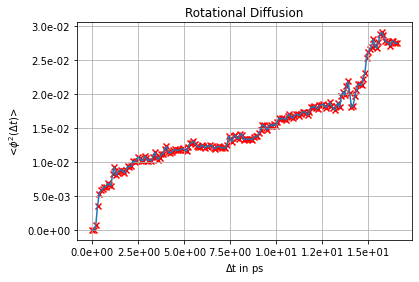

In [63]:
traj.plot_d_rot(rmsd, timestep=(traj.n_snapshots*0.0005))

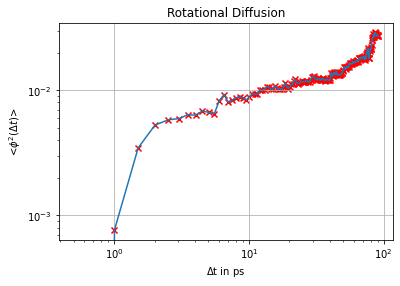

In [66]:
fig, ax = plt.subplots()

ax.scatter(0.0005*1000*np.linspace(0,len(rmsd), len(rmsd)), rmsd, color="red", marker="x")
ax.plot(0.0005*1000*np.linspace(0,len(rmsd), len(rmsd)), rmsd)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
ax.set_xlabel("$\Delta$t in ps")
ax.grid()
ax.set_ylabel("<$\phi^2(\Delta t)$>")
ax.set_title("Rotational Diffusion")

plt.yscale("log")
plt.xscale("log")
plt.show()

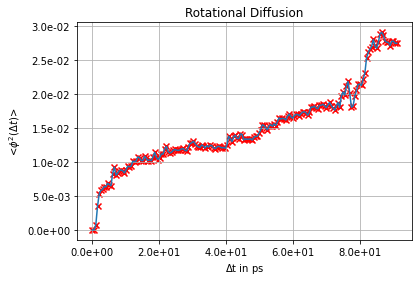

In [68]:
fig, ax = plt.subplots()

ax.scatter(0.0005*1000*np.linspace(0,len(rmsd), len(rmsd)), rmsd, color="red", marker="x")
ax.plot(0.0005*1000*np.linspace(0,len(rmsd), len(rmsd)), rmsd)
ax.yaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.1e'))
ax.set_xlabel("$\Delta$t in ps")
ax.grid()
ax.set_ylabel("<$\phi^2(\Delta t)$>")
ax.set_title("Rotational Diffusion")

plt.show()

In [47]:
traj2 = Trajectory("reduced_water.lammpstrj")
traj2.get_box_size()
traj2.s1, traj2.s2 = traj2.split_species()
print(traj2.s1)

Processing Snapshot:1
[array([[5.92600e+03, 1.00000e+00, 1.70260e-01, 2.87872e-01, 3.48330e-02],
       [1.16020e+04, 1.00000e+00, 1.25171e-01, 4.25715e-01, 2.22317e-01],
       [1.03470e+04, 1.00000e+00, 9.17387e-03, 4.11117e-01, 9.73607e-01],
       ...,
       [3.60300e+03, 1.00000e+00, 9.48402e-01, 5.29586e-01, 5.46967e-01],
       [3.60200e+03, 1.00000e+00, 9.20487e-01, 5.25505e-01, 5.50430e-01],
       [2.98300e+03, 1.00000e+00, 8.75902e-01, 5.02455e-01, 6.35631e-01]])]


In [48]:
traj2.indexlist, _ = traj2.get_neighbour_KDT(mode="pbc")

Atribute Error occured(recieved list instead of numpy array) using first element of list instead


In [49]:
traj2.get_displace(snapshot = 0, id = None, distance=0.5, eps=0.01, dp_factor = 0.99,
                     path=None, num_traj=None)

0.37333755555796955
distance too far next O
0.5706349544963049
distance too far next O
0.6039576722360931
distance too far next O
0.6157085454378963
distance too far next O
0.4741110273269332
distance too far next O
0.4269542310623001
distance too far next O
0.5898473724265032
distance too far next O
0.3018054030762206
distance too far next O
0.3816345303742837
distance too far next O
0.2249826956017951
distance too far next O
0.4943871787708496
displace
trajectory saved as water.data


In [16]:
traj.group_molecules()

Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
Atribute Error occured(recieve

In [25]:
traj.get_ion_distance()

array([[0.00000000e+00, 9.74471000e-01, 6.48596000e-01, ...,
        6.99036000e-01, 3.12085000e-01, 2.07666506e-01],
       [1.00000000e+00, 8.20679000e-01, 4.37983000e-01, ...,
        6.95657000e-01, 3.13206000e-01, 3.90856603e-01],
       [2.00000000e+00, 8.22932000e-01, 4.34909000e-01, ...,
        6.90487000e-01, 3.07421000e-01, 3.95979244e-01],
       ...,
       [6.70800000e+03, 3.91601000e-01, 7.02130000e-01, ...,
        7.39527000e-01, 2.40548000e-01, 4.15018401e-02],
       [6.70900000e+03, 3.86452000e-02, 9.89095000e-01, ...,
        7.34320000e-01, 2.16037000e-01, 4.50582879e-01],
       [6.71000000e+03, 3.92238000e-01, 7.26479000e-01, ...,
        3.59772000e-01, 1.96581000e-01, 6.08127191e-01]])

In [22]:
traj.remove_atoms(N=126)
#def remove_atoms(self, N=1, snap=0, atom_id=None, format_out="lammps"):

(128, 5) (256, 5)
Atribute Error occured(recieved list instead of numpy array) using first element of list instead
(2, 5) (4, 5)
